# Carga y Preprocesamiento de Datos

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import folium
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from folium.plugins import HeatMap
import zipfile
import warnings
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import xgboost as xgb

In [2]:
# Configuración para mostrar números completos
pd.set_option('display.float_format', '{:.2f}'.format)

# URL del archivo CSV
url = "https://hdvirtual.us.es/discovirt/index.php/s/SPcCmBgNgPexBjm/download/UK_Property_Price_Data_1995-2023.csv"

# Definir la ruta local donde se guardará el archivo CSV
local_file_path = "./UK_Property_Price_Data_1995-2023.csv"

# Especificar manualmente los tipos de datos para evitar errores de inferencia
dtype_spec = {
    'Transaction_unique_identifier': 'object',
    'PAON': 'object',
    'SAON': 'object',
    'Price': 'float64',
    'Postcode': 'object',
    'Property_Type': 'object',
    'Old/New': 'object',
    'Duration': 'object',
    'Street': 'object',
    'Locality': 'object',
    'Town/City': 'object',
    'District': 'object',
    'County': 'object',
    'PPDCategory_Type': 'object',
    'Record_Status': 'object'
}

# Tamaño mínimo esperado para el archivo (3.8 GB en bytes)
min_file_size = 3800000000  # 3.8 GB en bytes

# Función para descargar un archivo con progreso
def download_file_with_progress(url, local_file_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # Tamaño del bloque (1 KB)
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

    with open(local_file_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    # Verificar si se descargó el archivo completo
    if total_size != 0 and progress_bar.n != total_size:
        print("ERROR: No se descargó el archivo correctamente.")
    else:
        print("Descarga completada.")

# Verificar si el archivo ya ha sido descargado y si tiene el tamaño correcto
if not os.path.exists(local_file_path):
    print("Archivo no encontrado. Descargando desde la URL...")
    download_file_with_progress(url, local_file_path)
elif os.path.getsize(local_file_path) < min_file_size:
    print("Archivo incompleto. Descargando nuevamente desde la URL...")
    download_file_with_progress(url, local_file_path)
else:
    print("Archivo encontrado en local. Leyendo desde el archivo local...")

# Leer el archivo según corresponda
if not os.path.exists(local_file_path) or os.path.getsize(local_file_path) < min_file_size:
    # Leer el archivo desde la URL usando Dask
    df_dask = dd.read_csv(url, dtype=dtype_spec, blocksize="100MB")

    # Guardar el archivo en local para uso futuro
    df_dask.to_csv(local_file_path, single_file=True, index=False)
    print("Archivo descargado y guardado en local.")
else:
    # Leer el archivo desde la ubicación local
    df_dask = dd.read_csv(local_file_path, dtype=dtype_spec, blocksize="100MB")
    print("Archivo leído desde local.")

Archivo encontrado en local. Leyendo desde el archivo local...
Archivo leído desde local.


In [3]:
# Identificar las columnas categóricas en el dataframe
categorical_columns = ['Property Type', 'Old/New', 'Duration', 'PPD Category Type', 'Record Status - monthly file only', 'District']

# Categorizar las columnas primero para asegurar que Dask las trate adecuadamente
df_dask = df_dask.categorize(columns=categorical_columns)

In [4]:
# Verificar si el archivo reducido ya existe
output_file = './UK_Property_Price_Data_1995-2023_Reduced.csv'

if not os.path.exists(output_file):
    print("El archivo no existe. Se procederá a realizar el muestreo estratificado y guardarlo.")

    # Ver cuántos chunks se procesarán
    num_chunks = df_dask.npartitions
    print(f"El archivo se dividirá en {num_chunks} chunks.")

    # Escribir el encabezado solo la primera vez
    df_dask.head(0).to_csv(output_file, mode='w', header=True, index=False)

    # Función para muestreo estratificado
    def stratified_sample(df, frac=40000/28276228):
        return df.groupby(categorical_columns, observed=True, group_keys=False).apply(lambda x: x.sample(frac=frac), meta=df)

    # Procesar cada chunk de datos, aplicar muestreo y guardar incrementalmente
    for i, chunk in enumerate(df_dask.to_delayed()):
        print(f"Procesando chunk {i+1} de {num_chunks}...")
        chunk_df = dd.from_delayed([chunk])  # Convertir cada chunk en un dataframe
        chunk_sampled = stratified_sample(chunk_df)  # Aplicar muestreo estratificado

        # Guardar el chunk muestreado en el archivo CSV (añadir al archivo)
        chunk_sampled.compute().to_csv(output_file, mode='a', header=False, index=False)  # Añadir al archivo existente

    print("Proceso completado, archivo CSV guardado.")
else:
    print(f"El archivo '{output_file}' ya existe. Se procederá a leer el archivo.")

    # Leer el archivo existente
    df_sampled = pd.read_csv(output_file)

    print(f"El archivo ya existe y ha sido leído correctamente con {len(df_sampled)} filas.")

El archivo './UK_Property_Price_Data_1995-2023_Reduced.csv' ya existe. Se procederá a leer el archivo.
El archivo ya existe y ha sido leído correctamente con 30432 filas.


In [5]:
# Leer el archivo CSV completo
df = pd.read_csv(output_file)

# Asegurar que la columna 'Date of Transfer' está en formato datetime
df['Date of Transfer'] = pd.to_datetime(df['Date of Transfer'])

# Crear nuevas columnas para "Mes" y "Año"
df['Month'] = df['Date of Transfer'].dt.month
df['Year'] = df['Date of Transfer'].dt.year

In [6]:
df.head(3)

Transaction unique identifier     Price Date of Transfer  \
0  {3B759692-2201-4DCA-BE9E-9A32E19030D0}  26000.00       1995-07-05   
1  {A4AD3F99-6565-48A2-B3BD-F8C9CC0557FC}  69500.00       1995-04-07   
2  {A546F0BF-5479-4687-B608-37289CD3B35C} 168500.00       1995-06-28   

   Postcode Property Type Old/New Duration PAON SAON         Street  \
0   DE7 6DX             D       N        F  122  NaN    HEANOR ROAD   
1  BN17 6SF             D       N        F   35  NaN  CAPSTAN DRIVE   
2  MK18 3RG             D       N        F    4  NaN  LANGLEY CLOSE   

        Locality      Town/City        District           County  \
0        SMALLEY       ILKESTON    AMBER VALLEY       DERBYSHIRE   
1  LITTLEHAMPTON  LITTLEHAMPTON            ARUN      WEST SUSSEX   
2        WINSLOW     BUCKINGHAM  AYLESBURY VALE  BUCKINGHAMSHIRE   

  PPD Category Type Record Status - monthly file only  Month  Year  
0                 A                                 A      7  1995  
1                 A                                 A      4  1995  
2                 A                                 A      6  1995

## Missing Values

In [7]:
# Contar los valores faltantes (NaN) por cada columna
missing_values = df.isnull().sum()

# Mostrar el resultado
missing_values

Transaction unique identifier            0
Price                                    0
Date of Transfer                         0
Postcode                                22
Property Type                            0
Old/New                                  0
Duration                                 0
PAON                                     4
SAON                                 27478
Street                                 475
Locality                             10538
Town/City                                0
District                                 0
County                                   0
PPD Category Type                        0
Record Status - monthly file only        0
Month                                    0
Year                                     0
dtype: int64

In [8]:
# Lista de columnas que vamos a eliminar
columns_to_drop = ['Transaction unique identifier', 'Date of Transfer', 'PAON', 
                   'SAON', 'Street', 'Locality', 'Town/City', 'District', 'Record Status - monthly file only', 
                   'PPD Category Type']

# Filtrar las columnas que existen en el dataframe
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

# Eliminar solo las columnas que existen en el dataframe
if columns_to_drop_existing:
    df = df.drop(columns=columns_to_drop_existing)
    print(f"Las siguientes columnas se eliminaron: {columns_to_drop_existing}")
else:
    print("Las columnas ya han sido eliminadas")

Las siguientes columnas se eliminaron: ['Transaction unique identifier', 'Date of Transfer', 'PAON', 'SAON', 'Street', 'Locality', 'Town/City', 'District', 'Record Status - monthly file only', 'PPD Category Type']


## Outliers

In [9]:
# Histograma para comprobar outliers antes de eliminarlos
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='green')
plt.title('Distribución de Precios con outliers')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [10]:
# Calcular los cuartiles y el IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
print(f"Total de outliers detectados: {outliers.shape[0]}")

# Filtrar los datos sin outliers
data_without_outliers = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]


Total de outliers detectados: 1785


In [11]:
# Eliminar outliers usando IQR
data = data_without_outliers.copy()

In [12]:
# Histograma sin outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True, color='green')
plt.title('Distribución de Precios sin outliers')
plt.show()

## Feature Engineering

In [13]:
# Variable: Frecuencia de tipos de propiedad por condado
# Calculando la frecuencia de cada tipo de propiedad por condado
property_type_freq = data.groupby(['County', 'Property Type']).size() / data.groupby('County').size()
data['Property_Type_Frequency'] = data.set_index(['County', 'Property Type']).index.map(property_type_freq)

# Variable: Relación entre precio y tipo de propiedad
# Calculando el precio promedio por tipo de propiedad
average_price_by_property_type = data.groupby('Property Type')['Price'].transform('mean')
data['Price_Relative_to_Property_Type'] = data['Price'] / average_price_by_property_type

# Análisis Exploratorio de Datos (EDA)

In [14]:
data.head()

Price  Postcode Property Type Old/New Duration           County  Month  \
0  26000.00   DE7 6DX             D       N        F       DERBYSHIRE      7   
1  69500.00  BN17 6SF             D       N        F      WEST SUSSEX      4   
2 168500.00  MK18 3RG             D       N        F  BUCKINGHAMSHIRE      6   
3  66000.00   IP7 5HZ             D       N        F          SUFFOLK      6   
4  94950.00  SS11 8XY             D       N        F            ESSEX      2   

   Year  Property_Type_Frequency  Price_Relative_to_Property_Type  
0  1995                     0.33                             0.11  
1  1995                     0.24                             0.31  
2  1995                     0.32                             0.74  
3  1995                     0.41                             0.29  
4  1995                     0.30                             0.42

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28647 entries, 0 to 30431
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            28647 non-null  float64
 1   Postcode                         28629 non-null  object 
 2   Property Type                    28647 non-null  object 
 3   Old/New                          28647 non-null  object 
 4   Duration                         28647 non-null  object 
 5   County                           28647 non-null  object 
 6   Month                            28647 non-null  int32  
 7   Year                             28647 non-null  int32  
 8   Property_Type_Frequency          28647 non-null  float64
 9   Price_Relative_to_Property_Type  28647 non-null  float64
dtypes: float64(3), int32(2), object(5)
memory usage: 2.2+ MB


In [16]:
data.describe()

Price    Month     Year  Property_Type_Frequency  \
count  28647.00 28647.00 28647.00                 28647.00   
mean  164109.84     6.75  2007.25                     0.36   
std   105770.76     3.34     7.90                     0.14   
min     1500.00     1.00  1995.00                     0.00   
25%    80000.00     4.00  2001.00                     0.29   
50%   140000.00     7.00  2006.00                     0.36   
75%   225000.00    10.00  2014.00                     0.43   
max   493000.00    12.00  2023.00                     1.00   

       Price_Relative_to_Property_Type  
count                         28647.00  
mean                              1.00  
std                               0.63  
min                               0.01  
25%                               0.52  
50%                               0.88  
75%                               1.34  
max                               3.77

In [17]:
categorical_columns = ['Property Type', 'Old/New', 'Duration']

# Aplicar value_counts() a cada columna categórica
for col in categorical_columns:
    display(f"Frecuencia de valores en la columna '{col}':")
    display(data[col].value_counts())  # Aquí 'df' es tu dataframe Pandas
    display("\n" + "="*50 + "\n")  # Separador entre columnas

"Frecuencia de valores en la columna 'Property Type':"

Property Type
T    9434
S    9103
D    6051
F    4036
O      23
Name: count, dtype: int64

'\n==================================================\n'

"Frecuencia de valores en la columna 'Old/New':"

Old/New
N    28229
Y      418
Name: count, dtype: int64

'\n==================================================\n'

"Frecuencia de valores en la columna 'Duration':"

Duration
F    23780
L     4867
Name: count, dtype: int64

'\n==================================================\n'

## Correlación

In [18]:
# Seleccionar solo las variables numéricas
numeric_data = data[['Price', 'Month', 'Year', 'Property_Type_Frequency', 'Price_Relative_to_Property_Type']]

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

# Data Visualization

In [19]:
def plot_price_evolution_interactive(df):
    """
    Función para graficar la evolución interactiva del precio promedio de las propiedades a lo largo del tiempo.

    Parámetros:
    df: DataFrame - El conjunto de datos que contiene los precios y el año de transferencia.
    """
    # Agrupar por año y calcular el precio promedio
    data_grouped = data.groupby('Year')['Price'].mean().reset_index()

    # Crear la figura
    fig = go.Figure()

    # Añadir la traza del gráfico de línea
    fig.add_trace(go.Scatter(
        x=data_grouped['Year'],
        y=data_grouped['Price'],
        mode='lines+markers',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6, color='darkblue'),
        name='Precio promedio',
        hovertemplate='%{y:.2f} €<extra></extra>'
    ))

    # Añadir títulos y detalles del gráfico
    fig.update_layout(
        title="Evolución del Precio Promedio de Propiedades (1995-2023)",
        xaxis_title="Año",
        yaxis_title="Precio Promedio",
        template="plotly_white",
        hovermode="x",
        font=dict(family="Arial", size=12),
        width=900, height=600,
        xaxis=dict(
            tickmode='linear',
            tick0=1995,
            dtick=1
        ),
    )

    # Mostrar el gráfico
    fig.show()

# Llamar a la función con el dataframe limpio
plot_price_evolution_interactive(data)

In [20]:
def plot_price_distribution_by_property_type(df):
    """
    Función para graficar la distribución de los precios según el tipo de propiedad de manera más eficiente.

    Parámetros:
    df: DataFrame - El conjunto de datos que contiene los precios y el tipo de propiedad.
    """
    # Crear el gráfico de caja con Plotly Express sin puntos individuales
    fig = px.box(
        df,
        x='Property Type',
        y='Price',
        title='Distribución de Precios según el Tipo de Propiedad',
        labels={'Property Type': 'Tipo de Propiedad', 'Price': 'Precio (€)'},  # Etiquetas más claras
        template="plotly_white"
    )

    # Ajustar el layout y formato
    fig.update_layout(
        xaxis_title="Tipo de Propiedad",
        yaxis_title="Precio de Venta (€)",
        font=dict(family="Arial", size=12),
        width=900, height=600,
        yaxis=dict(tickprefix="€")
    )

    # Mostrar el gráfico
    fig.show()

# Llamar a la función con el dataframe limpio
plot_price_distribution_by_property_type(data)

In [21]:
def plot_price_trends_by_property_type(df):
    """
    Función para graficar las tendencias de precios a lo largo del tiempo para cada tipo de propiedad.

    Parámetros:
    df: DataFrame - El conjunto de datos que contiene los precios, el año, y el tipo de propiedad.
    """
    plt.figure(figsize=(10, 6))
    
    # Ignorar warnings de tipo FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        
        # Graficar la tendencia de los precios con Seaborn
        sns.lineplot(x='Year', y='Price', hue='Property Type', data=df)

    # Título y etiquetas de los ejes
    plt.title('Tendencias de precios a lo largo del tiempo para cada tipo de propiedad')
    plt.xlabel('Año')
    plt.ylabel('Precio')

    # Mostrar el gráfico
    plt.show()

# Llamar a la función con el dataframe limpio
plot_price_trends_by_property_type(data)

In [22]:
def plot_price_distribution_by_county(df, top_n=10):
    """
    Función para graficar la distribución de precios por los condados más representativos.
    
    Parámetros:
    df: DataFrame - El conjunto de datos que contiene precios y condados.
    top_n: int - El número de condados a mostrar basados en el número de transacciones.
    """
    # Obtener los top_n condados con más transacciones
    top_county = df['County'].value_counts().nlargest(top_n).index

    # Filtrar el dataframe para incluir solo esos condados
    df_filtered = df[df['County'].isin(top_county)]

    # Ignorar los warnings de tipo FutureWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        # Crear el gráfico de caja
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='County', y='Price', data=df_filtered, palette="Set3")
        plt.title(f'Distribución de precios por los {top_n} condados más representativos', fontsize=14)
        plt.xlabel('Condado', fontsize=12)
        plt.ylabel('Precio', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Llamar a la función con el dataframe limpio
plot_price_distribution_by_county(data, top_n=15)

In [23]:
def plot_price_evolution_new_vs_old(df):
    """
    Función para graficar la evolución de los precios de propiedades nuevas vs. de segunda mano a lo largo del tiempo.
    """
    plt.figure(figsize=(10, 6))

    # Suprimir el warning temporalmente
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        # Graficar la evolución de los precios con Seaborn
        sns.lineplot(x='Year', y='Price', hue='Old/New', data=df)

    # Título y etiquetas de los ejes
    plt.title('Evolución de los precios de propiedades nuevas vs. de segunda mano')
    plt.xlabel('Año')
    plt.ylabel('Precio')

    # Mostrar el gráfico
    plt.show()

# Llamar a la función con el dataframe limpio
plot_price_evolution_new_vs_old(data)

In [24]:
def plot_price_comparison_by_property_type_and_county(df, top_n_county=5):
    """
    Función para graficar la comparación de precios entre diferentes tipos de propiedad en los condados más representativos.
    """
    # Obtener los condados con más transacciones
    top_county = df['County'].value_counts().nlargest(top_n_county).index

    # Filtrar el dataframe para incluir solo esos condados
    df_filtered = df[df['County'].isin(top_county)]

    # Crear el gráfico de caja (boxplot) categorizado por tipo de propiedad
    g = sns.catplot(
        x='Property Type', y='Price', hue='County',
        data=df_filtered, kind='box', height=6, aspect=2,
        hue_order=top_county  # Asegura el orden
    )

    # Añadir título y etiquetas
    g.set_axis_labels("Tipo de Propiedad", "Precio")
    g.set_titles(f'Comparativa de precios entre tipos de propiedad en los {top_n_county} condados más representativos')
    g.set_xticklabels(rotation=45)
    
    # Mostrar el gráfico
    plt.show()

# Llamar a la función con el dataframe limpio
plot_price_comparison_by_property_type_and_county(data, top_n_county=5)

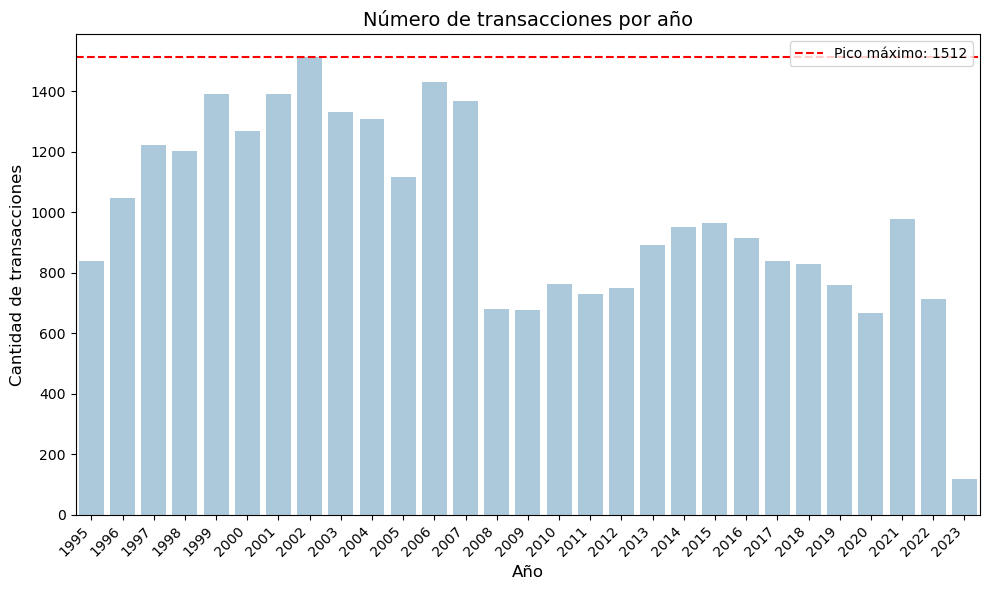

In [25]:
def plot_transactions_per_year(df):
    """
    Función para graficar el número de transacciones por año.
    """
    plt.figure(figsize=(10, 6))

    # Configuración de colores específicos si deseas controlar la paleta
    palette = sns.color_palette("Blues_d", n_colors=len(df['Year'].unique()))

    # Crear el gráfico de barras
    ax = sns.countplot(x='Year', data=df, color=palette[0])

    # Título y etiquetas
    plt.title('Número de transacciones por año', fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Cantidad de transacciones', fontsize=12)

    # Rotar las etiquetas del eje X para que sean legibles
    plt.xticks(rotation=45, ha='right')

    # Mostrar valores completos en el eje Y
    ax.yaxis.get_major_formatter().set_useOffset(False)  # Elimina el offset
    ax.yaxis.get_major_formatter().set_scientific(False)  # Desactiva la notación científica

    # Añadir líneas horizontales para resaltar picos
    max_value = df['Year'].value_counts().max()
    plt.axhline(y=max_value, color='red', linestyle='--', label=f'Pico máximo: {max_value}')

    # Mostrar leyenda
    plt.legend()

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

# Llamar a la función con el dataframe limpio
plot_transactions_per_year(data)


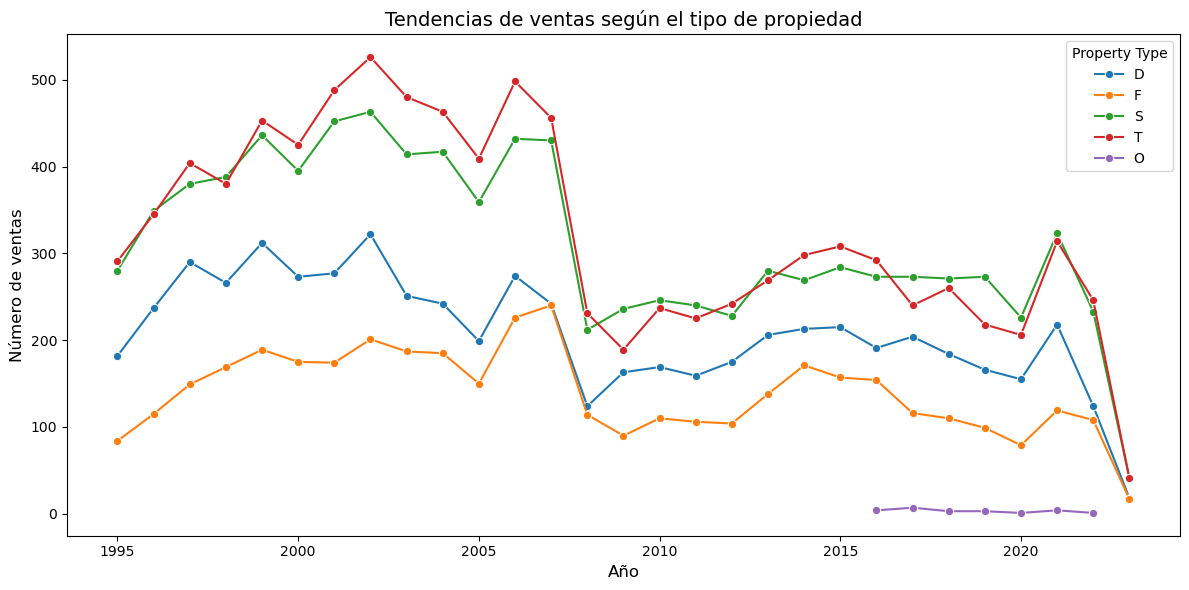

In [26]:
# Suprimir warnings específicos de FutureWarning en Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def plot_sales_trends_by_property_type_line(df):
    """
    Función para graficar las tendencias de ventas según el tipo de propiedad usando líneas.
    
    Parámetros:
    df: DataFrame - El conjunto de datos que contiene los tipos de propiedad y los años de transacción.
    """
    # Agrupar los datos por año y tipo de propiedad, y contar el número de ventas
    df_grouped = df.groupby(['Year', 'Property Type'], as_index=False).size()
    df_grouped.rename(columns={'size': 'Sales'}, inplace=True)

    # Crear el gráfico de líneas múltiple
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Sales', hue='Property Type', data=df_grouped, marker="o", palette='tab10')

    # Añadir título y etiquetas
    plt.title('Tendencias de ventas según el tipo de propiedad', fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Número de ventas', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Llamar a la función con el dataframe limpio
plot_sales_trends_by_property_type_line(data)

# Restablecer configuración de warnings al valor predeterminado
warnings.filterwarnings("default", category=FutureWarning, module="seaborn")

In [27]:
# Ignorar FutureWarnings en Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def plot_seasonality_with_rotated_month_names(df):
    """
    Función para graficar la estacionalidad en las transacciones a lo largo del año con nombres de los meses en el eje X rotados.
    """
    # Lista de nombres de los meses
    month_names = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                   'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='Month', data=df, palette="Blues_d")

    # Añadir etiquetas de valor en la parte superior de cada barra
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')

    # Calcular y trazar la línea de promedio
    avg = df['Month'].value_counts().mean()
    plt.axhline(y=avg, color='red', linestyle='--', label=f'Promedio: {int(avg)}')

    # Título y etiquetas
    plt.title('Estacionalidad en las transacciones a lo largo del año', fontsize=16)
    plt.xlabel('Mes', fontsize=12)
    plt.ylabel('Número de transacciones', fontsize=12)

    # Personalizar etiquetas del eje X
    ax.set_xticks(range(12))
    ax.set_xticklabels(month_names, rotation=45, ha='right')

    # Mostrar la leyenda
    plt.legend(loc='upper right')

    # Ajustar el diseño y mostrar la gráfica
    plt.tight_layout()
    plt.show()

# Llamar a la función
plot_seasonality_with_rotated_month_names(data)

C:\Users\ccontrerasm\AppData\Local\Temp\ipykernel_9032\2607902938.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




## Visualización Geográfica

In [28]:
# URL del archivo ZIP
url_zip = "https://download.geonames.org/export/zip/GB_full.csv.zip"
# Ruta de destino para guardar el archivo ZIP y el archivo descomprimido
zip_path = 'GB_full.csv.zip'
csv_path = 'GB_full.txt'

# Descargar el archivo ZIP
response = requests.get(url_zip)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Descomprimir el archivo y guardarlo como CSV
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')  # Extrae en la carpeta actual

# Cargar el archivo descomprimido como DataFrame
coordinates_data = pd.read_csv(csv_path, sep='\t', header=None, 
                               names=['Zone', 'Postcode', 'Town', 'Region', 'Country_Code', 
                                      'County', 'County2', 'AdminDistrict', 'AdminDistrictCode', 
                                      'Latitude', 'Longitude', 'Precision'],
                               dtype={'County2': str, 'AdminDistrict': str})

# Opcional: Eliminar el archivo ZIP para limpiar espacio
os.remove(zip_path)

# Unir ambos datasets en la columna 'Postcode'
data_merged = pd.merge(data, coordinates_data[['Postcode', 'Latitude', 'Longitude']], on='Postcode', how='left')

# Calcular la media del precio por código postal
media_precios_postal = data_merged.groupby('Postcode').agg(
    {'Price': 'mean', 'Latitude': 'first', 'Longitude': 'first'}).reset_index()

# Verificar el resultado
media_precios_postal.head()

Postcode     Price  Latitude  Longitude
0  AL1 1JL 450000.00     51.74      -0.32
1  AL1 1NG 250000.00     51.75      -0.34
2  AL1 1QD 134000.00     51.75      -0.33
3  AL1 1QF 239000.00     51.75      -0.33
4  AL1 1RN 212500.00     51.75      -0.34

In [29]:
# Eliminar filas con NaN en las columnas 'Latitude' o 'Longitude'
media_precios_postal_clean = media_precios_postal.dropna(subset=['Latitude', 'Longitude'])

# Verificar si hay algún NaN restante
media_precios_postal_clean.isnull().sum()

Postcode     0
Price        0
Latitude     0
Longitude    0
dtype: int64

In [30]:
# Crear el mapa centrado en el Reino Unido
mapa = folium.Map(location=[54.0, -2.0], zoom_start=6)

# Preparar datos para el Heatmap (latitud, longitud, y precios)
heat_data = [[row['Latitude'], row['Longitude'], row['Price']] for index, row in media_precios_postal_clean.iterrows()]

# Añadir el heatmap
HeatMap(heat_data, radius=15).add_to(mapa)

# Mostrar el mapa
mapa

# Machine Learning

In [31]:
data.head(3)

Price  Postcode Property Type Old/New Duration           County  Month  \
0  26000.00   DE7 6DX             D       N        F       DERBYSHIRE      7   
1  69500.00  BN17 6SF             D       N        F      WEST SUSSEX      4   
2 168500.00  MK18 3RG             D       N        F  BUCKINGHAMSHIRE      6   

   Year  Property_Type_Frequency  Price_Relative_to_Property_Type  
0  1995                     0.33                             0.11  
1  1995                     0.24                             0.31  
2  1995                     0.32                             0.74

In [32]:
# Separar la variable objetivo (Price) y la variable categórica para el encoding
X = data.drop(['Price', 'Postcode', 'County', 'Old/New', 'Month'], axis=1)
y = data['Price']

# Normalizar las variables numéricas
numerical_features = ['Year', 'Property_Type_Frequency', 'Price_Relative_to_Property_Type']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Crear una nueva columna combinada para la estratificación
X['stratify_col'] = (X['Property Type'].astype(str) + '_' + 
                     X['Duration'].astype(str))

# Crear dummies para las variables categóricas
categorical_features = ['Property Type', 'Duration']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Contar combinaciones para verificar las frecuencias
print("Frecuencias de las combinaciones:")
print(X['stratify_col'].value_counts())

# Filtrar combinaciones con menos de 5 instancias
counts = X['stratify_col'].value_counts()
X = X[X['stratify_col'].isin(counts[counts >= 5].index)]
y = y.loc[X.index]

# Dividir los datos en conjuntos de entrenamiento y prueba de manera estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['stratify_col']),  # Elimina la columna de estratificación después de la división
    y,
    test_size=0.3,  # Aumenta el tamaño de prueba si es necesario
    random_state=42,
    stratify=X['stratify_col']
)

# Verifica las dimensiones para asegurar que la división es correcta
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

Frecuencias de las combinaciones:
stratify_col
T_F    8932
S_F    8779
D_F    6051
F_L    4036
T_L     502
S_L     324
O_F      18
O_L       5
Name: count, dtype: int64
Tamaño de X_train: (20052, 8)
Tamaño de X_test: (8595, 8)
Tamaño de y_train: (20052,)
Tamaño de y_test: (8595,)


In [33]:
X_train.head()

Year  Property_Type_Frequency  Price_Relative_to_Property_Type  \
12637 -0.28                    -1.71                            -0.54   
21919  0.86                    -0.09                            -0.34   
23463  0.98                     0.41                             0.85   
10216 -0.54                     1.12                            -0.88   
23307  0.98                    -0.54                             0.48   

       Property Type_F  Property Type_O  Property Type_S  Property Type_T  \
12637            False            False            False            False   
21919            False            False             True            False   
23463            False            False             True            False   
10216            False            False            False             True   
23307            False            False             True            False   

       Duration_L  
12637       False  
21919       False  
23463       False  
10216       False  
23307       False

## Random Forest

In [34]:
# Define el modelo
rf_model = RandomForestRegressor(random_state=42)

# Define el rango de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Configurar el Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=20, cv=3, verbose=10, random_state=42)

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 1/3; 1/20] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.982 total time=   0.3s
[CV 2/3; 1/20] START max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 2/3; 1/20] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.981 total time=   0.3s
[CV 3/3; 1/20] START max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 3/3; 1/20] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=0.977 total time=   0.3s
[CV 1/3; 2/20] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/3; 2/20] END max_depth=10, max_features=sqrt, min_samples

c:\Users\ccontrerasm\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ccontrerasm\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ccontrerasm\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\ccontrerasm\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    va

Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [35]:
# Crear y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=30, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='log2', min_samples_split=5,
                      n_estimators=200, random_state=42)

In [36]:
# Hacer predicciones en el conjunto de entrenamiento y prueba
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Calcular las métricas para el conjunto de entrenamiento
rf_mse_train = mean_squared_error(y_train, rf_train_pred)
rf_r2_train = r2_score(y_train, rf_train_pred)
rf_mae_train = mean_absolute_error(y_train, rf_train_pred)
rf_mape_train = mean_absolute_percentage_error(y_train, rf_train_pred)

# Calcular las métricas para el conjunto de prueba
rf_mse_test = mean_squared_error(y_test, rf_test_pred)
rf_r2_test = r2_score(y_test, rf_test_pred)
rf_mae_test = mean_absolute_error(y_test, rf_test_pred)
rf_mape_test = mean_absolute_percentage_error(y_test, rf_test_pred)

# Mostrar los resultados
print("Random Forest - Conjunto de Entrenamiento:")
print("MSE:", rf_mse_train)
print("R²:", rf_r2_train)
print("MAE:", rf_mae_train)
print("MAPE:", rf_mape_train)

print("\nRandom Forest - Conjunto de Prueba:")
print("MSE:", rf_mse_test)
print("R²:", rf_r2_test)
print("MAE:", rf_mae_test)
print("MAPE:", rf_mape_test)

Random Forest - Conjunto de Entrenamiento:
MSE: 3923227.1782628587
R²: 0.9996487491733518
MAE: 851.4705583144313
MAPE: 0.010026251199480857

Random Forest - Conjunto de Prueba:
MSE: 12594791.691628637
R²: 0.9988783053323218
MAE: 1393.88356751544
MAPE: 0.015354372406594928


In [37]:
# Gráfico de Valores Reales vs. Predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_test_pred, alpha=0.5, c=np.abs(y_test - rf_test_pred), cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Random Forest - Valores Reales vs. Predicciones (Color según Error)')
plt.colorbar(label='Error Absoluto')
plt.grid()
plt.show()

In [38]:
# Gráfico de Residuos
plt.figure(figsize=(10, 6))
rf_residuals = y_test - rf_test_pred
plt.scatter(rf_test_pred, rf_residuals, alpha=0.5, c=np.abs(rf_residuals), cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Random Forest - Gráfico de Residuos')
plt.colorbar(label='Valor Absoluto de los Residuos')
plt.grid()
plt.show()


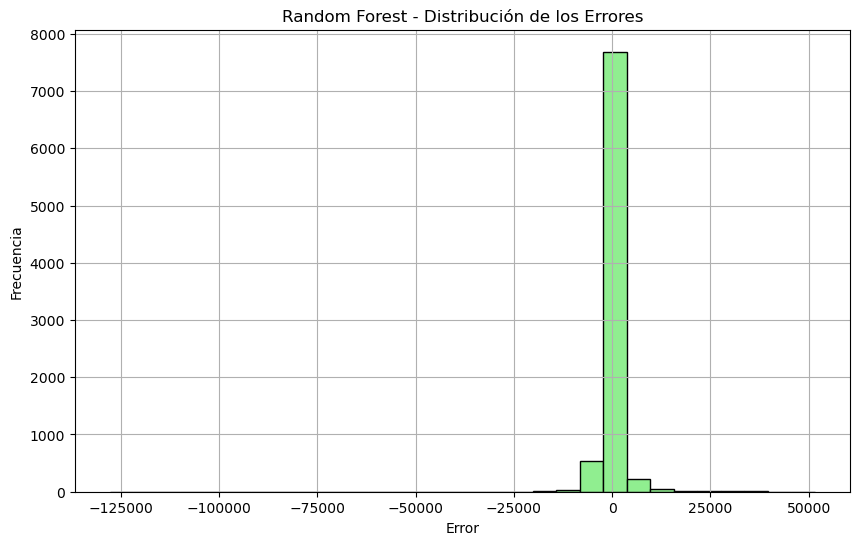

In [39]:
# Distribución de Errores
plt.figure(figsize=(10, 6))
plt.hist(rf_residuals, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Random Forest - Distribución de los Errores')
plt.grid()
plt.show()

## XGBoost

In [46]:
# Crear el modelo base de XGBoost
xgb_model = xgb.XGBRegressor()

# Definir el rango de hiperparámetros
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Configurar GridSearchCV para optimizar con R²
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='r2',  # Usar R² como métrica de evaluación
                           cv=3,  # Validación cruzada con 3 particiones
                           verbose=10)  # Usar todos los núcleos disponibles

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros: ", grid_search.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3; 1/32] START colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8
[CV 1/3; 1/32] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8;, score=0.983 total time=   0.2s
[CV 2/3; 1/32] START colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8
[CV 2/3; 1/32] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8;, score=0.982 total time=   0.0s
[CV 3/3; 1/32] START colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8
[CV 3/3; 1/32] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8;, score=0.981 total time=   0.0s
[CV 1/3; 2/32] START colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0
[CV 1/3; 2/32] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100

In [47]:
# Crear y entrenar el modelo
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, colsample_bytree=1.0, 
                             learning_rate=0.1, max_depth=6, n_estimators=150, subsample=1.0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [49]:
# Hacer predicciones en el conjunto de entrenamiento y prueba
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calcular las métricas para el conjunto de entrenamiento
xgb_mse_train = mean_squared_error(y_train, xgb_train_pred)
xgb_r2_train = r2_score(y_train, xgb_train_pred)
xgb_mae_train = mean_absolute_error(y_train, xgb_train_pred)
xgb_mape_train = mean_absolute_percentage_error(y_train, xgb_train_pred)

# Calcular las métricas para el conjunto de prueba
xgb_mse_test = mean_squared_error(y_test, xgb_test_pred)
xgb_r2_test = r2_score(y_test, xgb_test_pred)
xgb_mae_test = mean_absolute_error(y_test, xgb_test_pred)
xgb_mape_test = mean_absolute_percentage_error(y_test, xgb_test_pred)

# Mostrar los resultados
print("Xgboost - Conjunto de Entrenamiento:")
print("MSE:", xgb_mse_train)
print("R²:", xgb_r2_train)
print("MAE:", xgb_mae_train)
print("MAPE:", xgb_mape_train)

print("\Xgboost - Conjunto de Prueba:")
print("MSE:", xgb_mse_test)
print("R²:", xgb_r2_test)
print("MAE:", xgb_mae_test)
print("MAPE:", xgb_mape_test)

Xgboost - Conjunto de Entrenamiento:
MSE: 2081267.3868092438
R²: 0.9998136618511049
MAE: 709.5498154444441
MAPE: 0.005600107562050784
\Xgboost - Conjunto de Prueba:
MSE: 5547428.579995044
R²: 0.9995059449008877
MAE: 816.3370955417848
MAPE: 0.007498785850160523


<>:24: SyntaxWarning:

invalid escape sequence '\X'

<>:24: SyntaxWarning:

invalid escape sequence '\X'

C:\Users\ccontrerasm\AppData\Local\Temp\ipykernel_9032\3982857509.py:24: SyntaxWarning:

invalid escape sequence '\X'



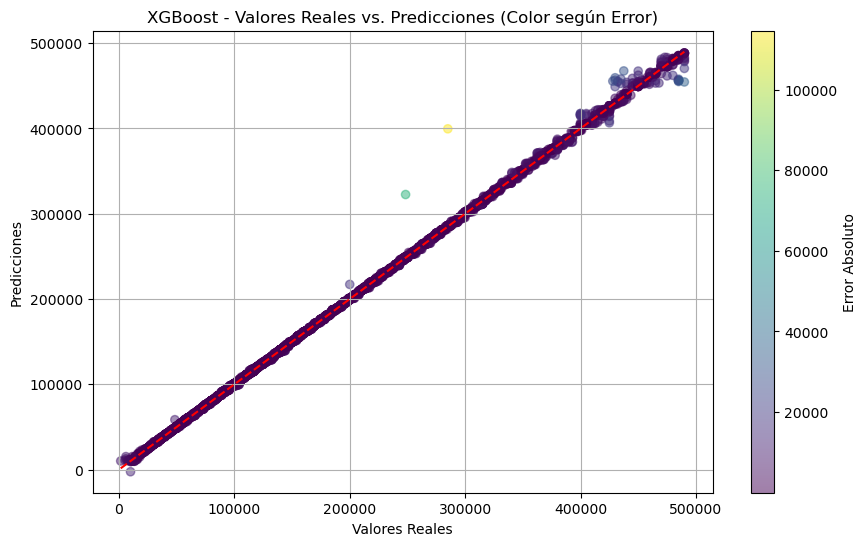

In [50]:
# Gráfico de Valores Reales vs. Predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_test_pred, alpha=0.5, c=np.abs(y_test - xgb_test_pred), cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('XGBoost - Valores Reales vs. Predicciones (Color según Error)')
plt.colorbar(label='Error Absoluto')
plt.grid()
plt.show()

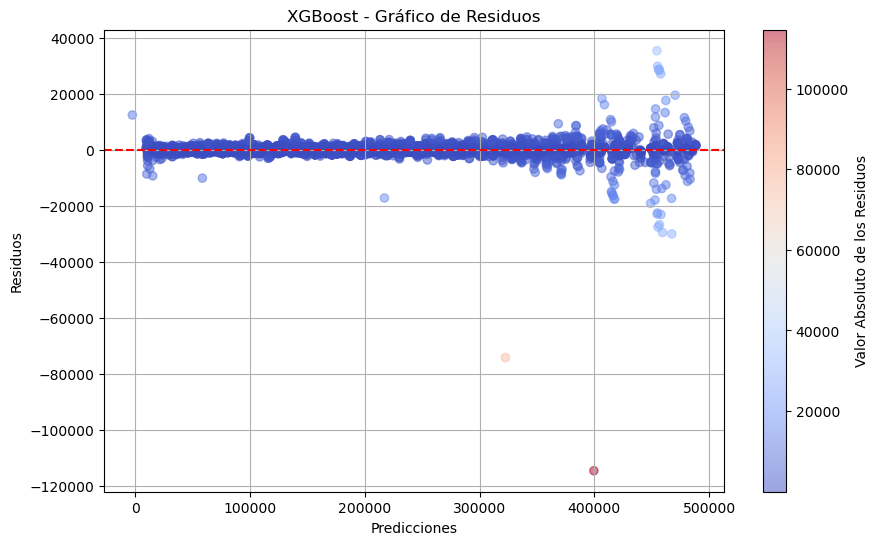

In [51]:
# Gráfico de Residuos
plt.figure(figsize=(10, 6))
xgb_residuals = y_test - xgb_test_pred
plt.scatter(xgb_test_pred, xgb_residuals, alpha=0.5, c=np.abs(xgb_residuals), cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('XGBoost - Gráfico de Residuos')
plt.colorbar(label='Valor Absoluto de los Residuos')
plt.grid()
plt.show()

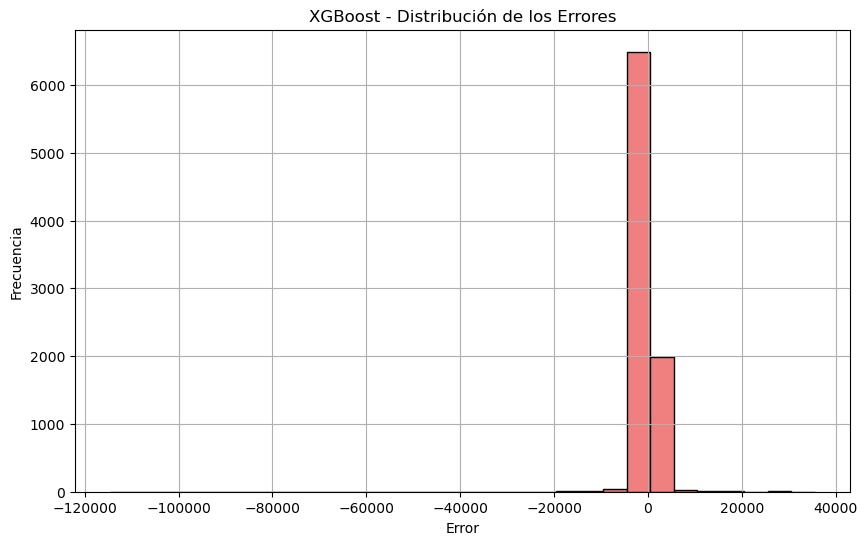

In [52]:
# Distribución de Errores
plt.figure(figsize=(10, 6))
plt.hist(xgb_residuals, bins=30, color='lightcoral', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('XGBoost - Distribución de los Errores')
plt.grid()
plt.show()

In [53]:
# Curvas de aprendizaje para XGBoost
train_sizes, train_scores_xgb, test_scores_xgb = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_xgb_mean = -train_scores_xgb.mean(axis=1)
test_scores_xgb_mean = -test_scores_xgb.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_xgb_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_xgb_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_xgb_mean - train_scores_xgb.std(axis=1),
                 train_scores_xgb_mean + train_scores_xgb.std(axis=1), alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_xgb_mean - test_scores_xgb.std(axis=1),
                 test_scores_xgb_mean + test_scores_xgb.std(axis=1), alpha=0.1, color="g")
plt.title("Learning Curves (XGBoost Regression)")
plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.grid()
plt.show()

## Redes Neuronales

In [54]:
# Crear y entrenar el modelo
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

c:\Users\ccontrerasm\AppData\Local\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [55]:
# Realizar predicciones en el conjunto de entrenamiento
mlp_train_pred = mlp_model.predict(X_train)

# Calcular métricas para el conjunto de entrenamiento
mlp_train_mse = mean_squared_error(y_train, mlp_train_pred)
mlp_train_r2 = r2_score(y_train, mlp_train_pred)
mlp_train_mae = mean_absolute_error(y_train, mlp_train_pred)
mlp_train_mape = np.mean(np.abs((y_train - mlp_train_pred) / y_train))

print("MLP - Conjunto de Entrenamiento:")
print("MSE:", mlp_train_mse)
print("R²:", mlp_train_r2)
print("MAE:", mlp_train_mae)
print("MAPE:", mlp_train_mape)

# Realizar predicciones en el conjunto de prueba
mlp_test_pred = mlp_model.predict(X_test)

# Calcular métricas para el conjunto de prueba
mlp_test_mse = mean_squared_error(y_test, mlp_test_pred)
mlp_test_r2 = r2_score(y_test, mlp_test_pred)
mlp_test_mae = mean_absolute_error(y_test, mlp_test_pred)
mlp_test_mape = np.mean(np.abs((y_test - mlp_test_pred) / y_test))

print("\nMLP - Conjunto de Prueba:")
print("MSE:", mlp_test_mse)
print("R²:", mlp_test_r2)
print("MAE:", mlp_test_mae)
print("MAPE:", mlp_test_mape)

MLP - Conjunto de Entrenamiento:
MSE: 5614.237996773025
R²: 0.9999994973511225
MAE: 24.926551161696104
MAPE: 0.000493699537999724

MLP - Conjunto de Prueba:
MSE: 12654.575472140044
R²: 0.9999988729809769
MAE: 27.43057985670443
MAPE: 0.0006595488764069917


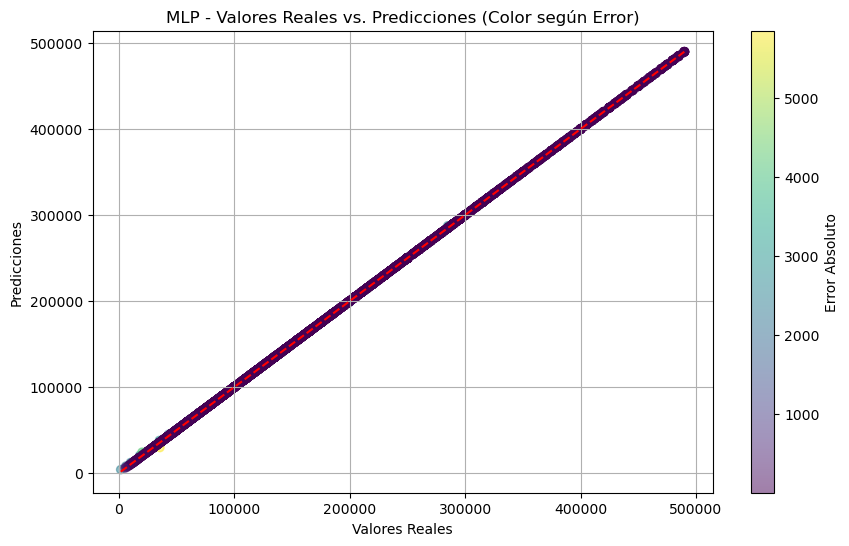

In [56]:
# Gráfico de Valores Reales vs. Predicciones para el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.scatter(y_test, mlp_test_pred, alpha=0.5, c=np.abs(y_test - mlp_test_pred), cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('MLP - Valores Reales vs. Predicciones (Color según Error)')
plt.colorbar(label='Error Absoluto')
plt.grid()
plt.show()

In [57]:
# Gráfico de Residuos para el conjunto de prueba
plt.figure(figsize=(10, 6))
mlp_residuals = y_test - mlp_test_pred
plt.scatter(mlp_test_pred, mlp_residuals, alpha=0.5, c=np.abs(mlp_residuals), cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('MLP - Gráfico de Residuos')
plt.colorbar(label='Valor Absoluto de los Residuos')
plt.grid()
plt.show()

In [58]:
# Distribución de los Errores en el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.hist(mlp_residuals, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('MLP - Distribución de los Errores')
plt.grid()
plt.show()

## LightGBM

In [59]:
# Crear y entrenar el modelo
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 20052, number of used features: 7
[LightGBM] [Info] Start training from score 163978.784111


LGBMRegressor(random_state=42)

In [60]:
# Realizar predicciones en el conjunto de entrenamiento
lgb_train_pred = lgb_model.predict(X_train)

# Calcular las métricas para el conjunto de entrenamiento
lgb_train_mse = mean_squared_error(y_train, lgb_train_pred)
lgb_train_r2 = r2_score(y_train, lgb_train_pred)
lgb_train_mae = mean_absolute_error(y_train, lgb_train_pred)
lgb_train_mape = np.mean(np.abs((y_train - lgb_train_pred) / y_train))

# Realizar predicciones en el conjunto de prueba
lgb_test_pred = lgb_model.predict(X_test)

# Calcular las métricas para el conjunto de prueba
lgb_test_mse = mean_squared_error(y_test, lgb_test_pred)
lgb_test_r2 = r2_score(y_test, lgb_test_pred)
lgb_test_mae = mean_absolute_error(y_test, lgb_test_pred)
lgb_test_mape = np.mean(np.abs((y_test - lgb_test_pred) / y_test))

# Mostrar los resultados
print("LightGBM - Conjunto de Entrenamiento:")
print("MSE:", lgb_train_mse)
print("R²:", lgb_train_r2)
print("MAE:", lgb_train_mae)
print("MAPE:", lgb_train_mape)

print("\nLightGBM - Conjunto de Prueba:")
print("MSE:", lgb_test_mse)
print("R²:", lgb_test_r2)
print("MAE:", lgb_test_mae)
print("MAPE:", lgb_test_mape)

LightGBM - Conjunto de Entrenamiento:
MSE: 4422775.885952391
R²: 0.9996040240303625
MAE: 956.1416201320854
MAPE: 0.008303995649085096

LightGBM - Conjunto de Prueba:
MSE: 10379560.197807308
R²: 0.9990755942923245
MAE: 1028.3043428251294
MAPE: 0.009488107640954507


In [61]:
# Gráfico de Valores Reales vs. Predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgb_test_pred, alpha=0.5, c=np.abs(y_test - lgb_test_pred), cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('LightGBM - Valores Reales vs. Predicciones (Color según Error)')
plt.colorbar(label='Error Absoluto')
plt.grid()
plt.show()

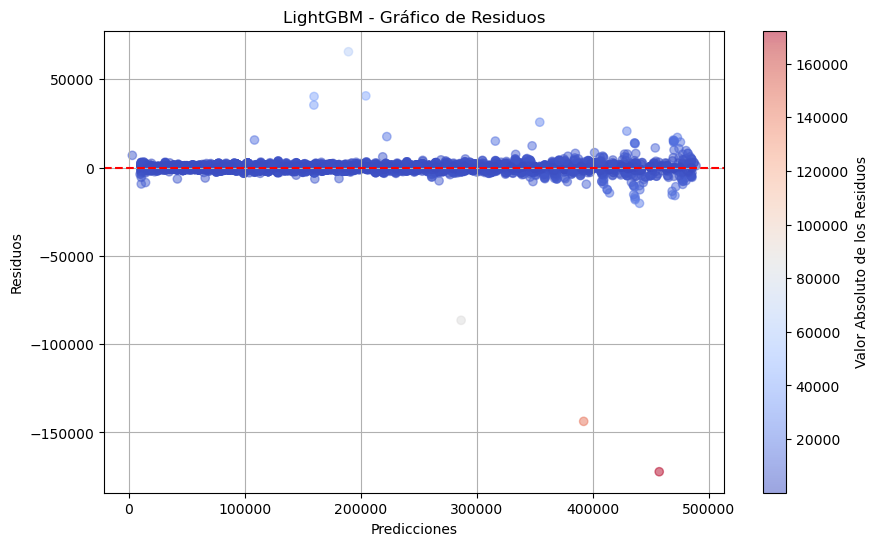

In [62]:
# Gráfico de Residuos
plt.figure(figsize=(10, 6))
lgb_residuals = y_test - lgb_test_pred
plt.scatter(lgb_test_pred, lgb_residuals, alpha=0.5, c=np.abs(lgb_residuals), cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('LightGBM - Gráfico de Residuos')
plt.colorbar(label='Valor Absoluto de los Residuos')
plt.grid()
plt.show()

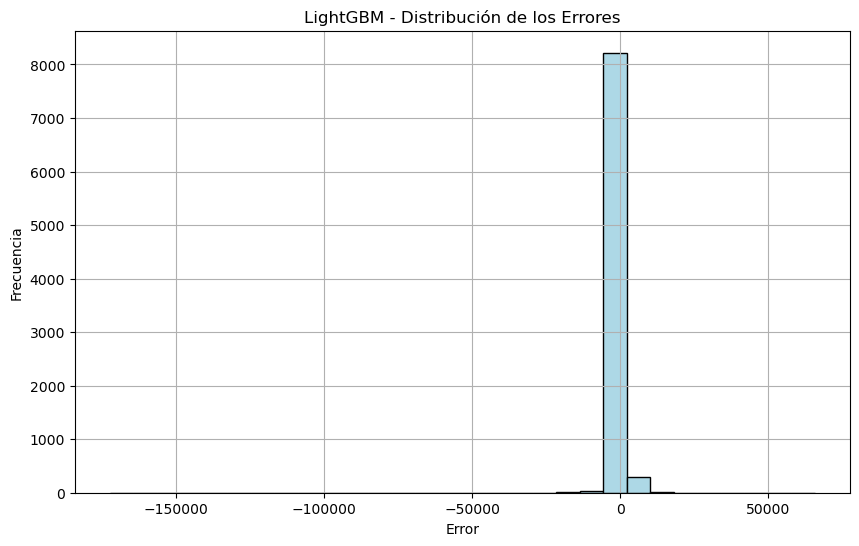

In [63]:
# Distribución de Errores
plt.figure(figsize=(10, 6))
plt.hist(lgb_residuals, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('LightGBM - Distribución de los Errores')
plt.grid()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 1604, number of used features: 7
[LightGBM] [Info] Start training from score 163329.126559
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 3208, number of used features: 7
[LightGBM] [Info] Start training from score 163218.103180
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

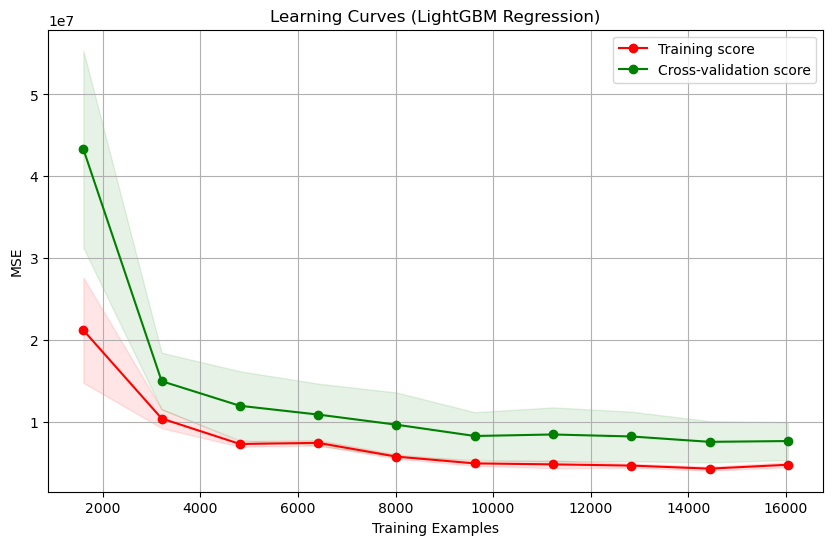

In [64]:
# Curvas de aprendizaje para LightGBM
train_sizes, train_scores_lgb, test_scores_lgb = learning_curve(
    lgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_lgb_mean = -train_scores_lgb.mean(axis=1)
test_scores_lgb_mean = -test_scores_lgb.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_lgb_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_lgb_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_lgb_mean - train_scores_lgb.std(axis=1),
                 train_scores_lgb_mean + train_scores_lgb.std(axis=1), alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_lgb_mean - test_scores_lgb.std(axis=1),
                 test_scores_lgb_mean + test_scores_lgb.std(axis=1), alpha=0.1, color="g")
plt.title("Learning Curves (LightGBM Regression)")
plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.grid()
plt.show()

## CatBoost

In [65]:
# Crear y entrenar el modelo
cat_model = CatBoostRegressor(silent=True, random_state=42)
cat_model.fit(X_train, y_train)

In [66]:
# Realizar predicciones para el conjunto de entrenamiento
cat_train_pred = cat_model.predict(X_train)

# Calcular las métricas para el conjunto de entrenamiento
cat_train_mse = mean_squared_error(y_train, cat_train_pred)
cat_train_r2 = r2_score(y_train, cat_train_pred)
cat_train_mae = mean_absolute_error(y_train, cat_train_pred)
cat_train_mape = np.mean(np.abs((y_train - cat_train_pred) / y_train))

# Realizar predicciones para el conjunto de prueba
cat_test_pred = cat_model.predict(X_test)

# Calcular las métricas para el conjunto de prueba
cat_test_mse = mean_squared_error(y_test, cat_test_pred)
cat_test_r2 = r2_score(y_test, cat_test_pred)
cat_test_mae = mean_absolute_error(y_test, cat_test_pred)
cat_test_mape = np.mean(np.abs((y_test - cat_test_pred) / y_test))

# Imprimir los resultados
print("CatBoost - Conjunto de Entrenamiento:")
print("MSE:", cat_train_mse)
print("R²:", cat_train_r2)
print("MAE:", cat_train_mae)
print("MAPE:", cat_train_mape)

print("\nCatBoost - Conjunto de Prueba:")
print("MSE:", cat_test_mse)
print("R²:", cat_test_r2)
print("MAE:", cat_test_mae)
print("MAPE:", cat_test_mape)

CatBoost - Conjunto de Entrenamiento:
MSE: 1701287.9280498873
R²: 0.999847681828265
MAE: 671.8109680892945
MAPE: 0.0055675453172308285

CatBoost - Conjunto de Prueba:
MSE: 3759798.8675363543
R²: 0.9996651515606993
MAE: 766.2082011773384
MAPE: 0.00697095138908491


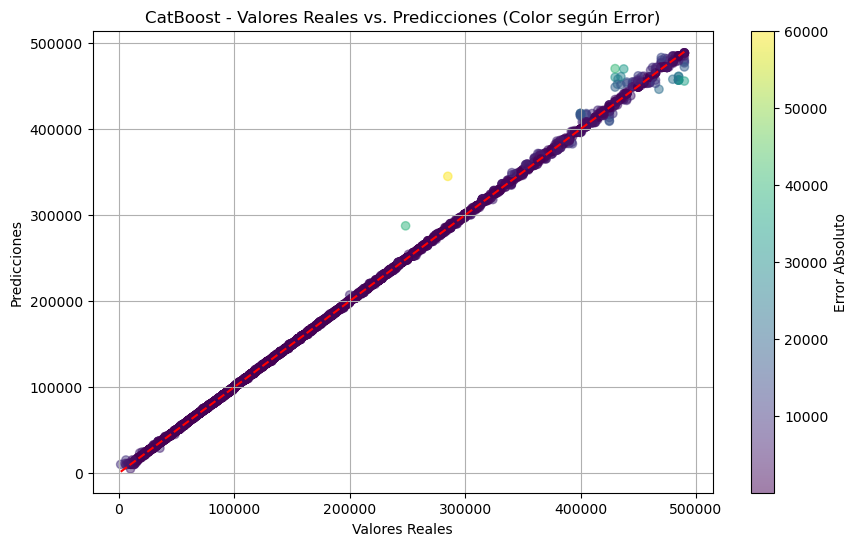

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, cat_test_pred, alpha=0.5, c=np.abs(y_test - cat_test_pred), cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('CatBoost - Valores Reales vs. Predicciones (Color según Error)')
plt.colorbar(label='Error Absoluto')
plt.grid()
plt.show()

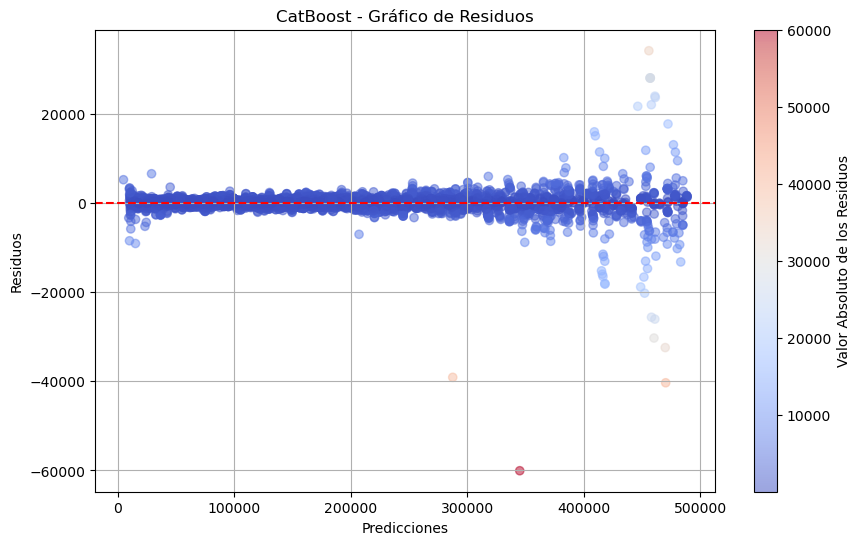

In [68]:
plt.figure(figsize=(10, 6))
cat_residuals = y_test - cat_test_pred
plt.scatter(cat_test_pred, cat_residuals, alpha=0.5, c=np.abs(cat_residuals), cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('CatBoost - Gráfico de Residuos')
plt.colorbar(label='Valor Absoluto de los Residuos')
plt.grid()
plt.show()

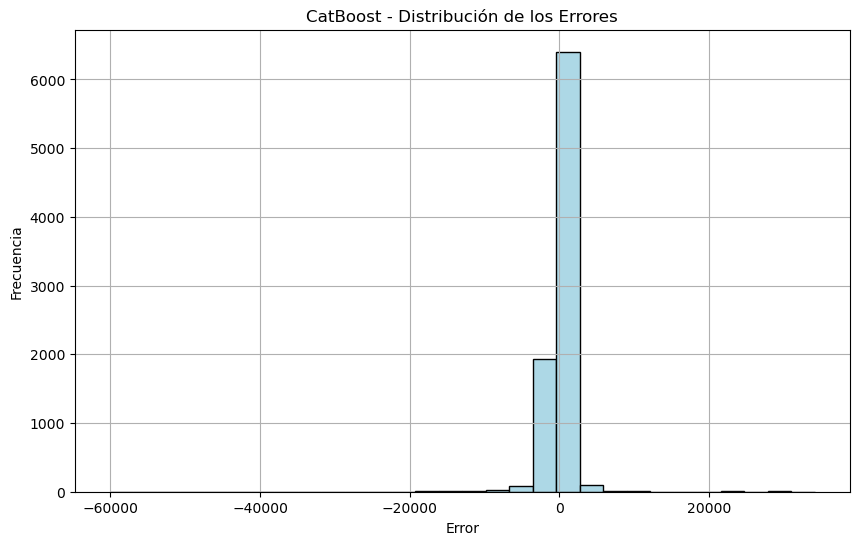

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(cat_residuals, bins=30, color='lightblue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('CatBoost - Distribución de los Errores')
plt.grid()
plt.show()

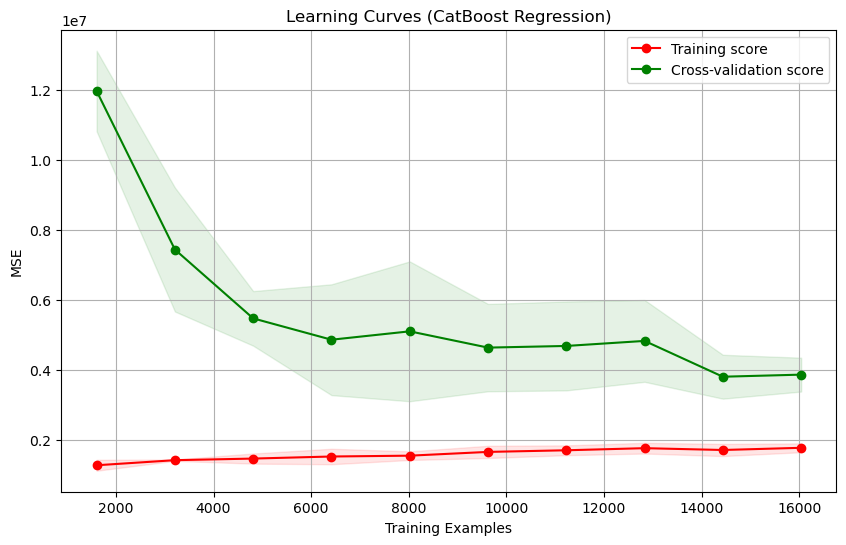

In [70]:
# Generar las curvas de aprendizaje para CatBoost
train_sizes, train_scores_cat, test_scores_cat = learning_curve(
    cat_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_cat_mean = -train_scores_cat.mean(axis=1)
test_scores_cat_mean = -test_scores_cat.mean(axis=1)

# Plotear las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_cat_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_cat_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_cat_mean - train_scores_cat.std(axis=1),
                 train_scores_cat_mean + train_scores_cat.std(axis=1), alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_cat_mean - test_scores_cat.std(axis=1),
                 test_scores_cat_mean + test_scores_cat.std(axis=1), alpha=0.1, color="g")
plt.title("Learning Curves (CatBoost Regression)")
plt.xlabel("Training Examples")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.grid()
plt.show()

# Resumen Modelos

In [71]:
pd.options.display.float_format = '{:.4f}'.format

# Crear un DataFrame con los resultados ordenados
resultados = {
    'Modelo': ['Random Forest', 'XGBoost', 'MLP', 'LightGBM', 'CatBoost'],
    'R² Entrenamiento': [rf_r2_train, xgb_r2_train, mlp_train_r2, lgb_train_r2, cat_train_r2],
    'R² Prueba': [rf_r2_test, xgb_r2_test, mlp_test_r2, lgb_test_r2, cat_test_r2],
    'MSE Entrenamiento': [rf_mse_train, xgb_mse_train, mlp_train_mse, lgb_train_mse, cat_train_mse],
    'MSE Prueba': [rf_mse_test, xgb_mse_test, mlp_test_mse, lgb_test_mse, cat_test_mse],
    'MAE Entrenamiento': [rf_mae_train, xgb_mae_train, mlp_train_mae, lgb_train_mae, cat_train_mae],
    'MAE Prueba': [rf_mae_test, xgb_mae_test, mlp_test_mae, lgb_test_mae, cat_test_mae],
    'MAPE Entrenamiento': [rf_mape_train, xgb_mape_train, mlp_train_mape, lgb_train_mape, cat_train_mape],
    'MAPE Prueba': [rf_mape_test, xgb_mape_test, mlp_test_mape, lgb_test_mape, cat_test_mape]
}

resultados_df = pd.DataFrame(resultados)

# Mostrar la tabla
resultados_df

Modelo  R² Entrenamiento  R² Prueba  MSE Entrenamiento  \
0  Random Forest            0.9996     0.9989       3923227.1783   
1        XGBoost            0.9998     0.9995       2081267.3868   
2            MLP            1.0000     1.0000          5614.2380   
3       LightGBM            0.9996     0.9991       4422775.8860   
4       CatBoost            0.9998     0.9997       1701287.9280   

     MSE Prueba  MAE Entrenamiento  MAE Prueba  MAPE Entrenamiento  \
0 12594791.6916           851.4706   1393.8836              0.0100   
1  5547428.5800           709.5498    816.3371              0.0056   
2    12654.5755            24.9266     27.4306              0.0005   
3 10379560.1978           956.1416   1028.3043              0.0083   
4  3759798.8675           671.8110    766.2082              0.0056   

   MAPE Prueba  
0       0.0154  
1       0.0075  
2       0.0007  
3       0.0095  
4       0.0070